In [1]:
import yfinance as yahooFinance
import pandas as pd
import datetime

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

startDate = datetime.datetime(2006, 2, 6) # modifying this from 1,1,06 to 2,6,06
endDate = datetime.datetime(2020, 12, 31)

vti = yahooFinance.Ticker("VTI").history(start=startDate,end=endDate).reset_index()
agg = yahooFinance.Ticker("AGG").history(start=startDate,end=endDate).reset_index()
dbc = yahooFinance.Ticker("DBC").history(start=startDate,end=endDate).reset_index()
vix = yahooFinance.Ticker("^VIX").history(start=startDate,end=endDate).reset_index()
 
all_assets = [vti, agg, dbc, vix]
labels = ["vti", "agg","dbc","vix"]

# look at dividends, capital gains

/Users/samuelmeisner/anaconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
data = pd.DataFrame()
for i, asset in enumerate(all_assets):
    asset = asset.reset_index()
    lb = labels[i]
    data[lb] = asset['Close']

In [57]:
np.random.seed(123)

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame, epochs=100):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
            
        fit_predict_data = data_w_ret[np.newaxis,:]    
        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=epochs, shuffle=False, verbose=0)
        return self.model.predict(fit_predict_data)[0]

In [58]:
model = Model()

In [59]:
coeffs = model.get_allocations(data, epochs = 10)

1/1 [==============================] - 0s 139ms/step


In [60]:
coeffs

array([0.03676006, 0.04071275, 0.15269107, 0.76983607], dtype=float32)

In [61]:
model.data.shape

TensorShape([3751, 4])

Notes: 
- sharpe needs data parameter - subset by window size.
- fit_predict data needs to be same dimension as in other attempt (below).
- but broken up into test and train
- new function for test needs to be made on separate test data.
- train, get allocations separate functions.

## Below here is Sam's first attempt (failed to converge):

In [2]:
for i, asset in enumerate(all_assets):
    asset = asset.reset_index()
    asset['Returns'] = (asset['Close']-asset['Open'])/asset['Open']
    asset['Date'] = asset['Date'].dt.date
    all_assets[i] = asset

In [3]:
returns = pd.DataFrame()
returns['Date'] = all_assets[0]['Date']
for i, l in enumerate(labels):
    returns[l] = all_assets[i]['Close']
    returns[l + '_return'] = all_assets[i]['Returns']

In [4]:
returns

,Date,vti,vti_return,agg,agg_return,dbc,dbc_return,vix,vix_return
0,2006-02-06,45.108852,0.001903,57.877361,0.001399,20.889496,-0.014257,13.040000,-0.029039
1,2006-02-07,44.669655,-0.007143,57.836926,-0.001894,20.285255,-0.022869,13.590000,0.029545
2,2006-02-08,44.991024,0.006068,57.808090,-0.000998,20.198935,-0.003831,12.830000,-0.043251
3,2006-02-09,44.905331,-0.004670,57.842701,0.000200,20.388838,0.002547,13.120000,0.044586
4,2006-02-10,44.998161,0.002865,57.721420,-0.001997,20.017664,-0.019450,12.870000,-0.035955
...,...,...,...,...,...,...,...,...,...
3747,2020-12-23,184.022522,-0.001911,109.330154,0.000594,13.794738,0.006220,23.309999,-0.007663
3748,2020-12-24,184.330368,-0.000311,109.432182,0.000424,13.832635,0.004818,21.530001,-0.041833
3749,2020-12-28,185.496643,-0.002826,109.450722,0.000339,13.747366,-0.005483,21.700001,-0.018544
3750,2020-12-29,184.722305,-0.008365,109.469292,-0.000254,13.785263,0.001376,23.080000,0.068024


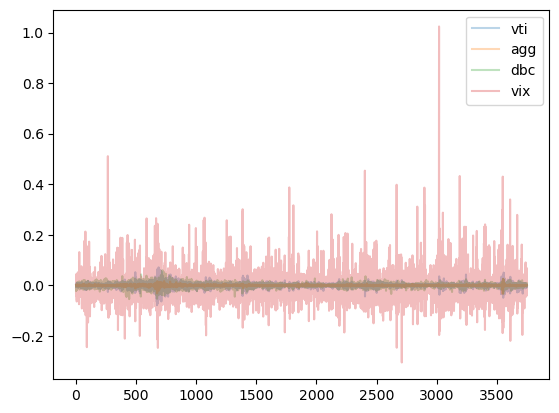

In [5]:
import matplotlib.pyplot as plt
plt.plot(returns['vti_return'],label="vti", alpha=0.3)
plt.plot(returns['agg_return'],label="agg", alpha=0.3)
plt.plot(returns['dbc_return'],label="dbc", alpha=0.3)
plt.plot(returns['vix_return'],label="vix", alpha=0.3)
plt.legend()
plt.show()

In [6]:
window = 50  

# Function to create sequence with lookback
def create_sequence(data, lookback):
    X = []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
    return np.array(X)

# Create sequences with the lookback window
X = create_sequence(returns.drop(columns=["Date"]), window)

# Splitting data into training and testing sets
train_size = int(len(X) * 0.8)  # 80% for training
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]

In [7]:
X_train[np.random.randint(0, X_train.shape[0])].shape

(50, 8)

In [8]:
X_train = torch.tensor(X_train)

In [54]:
def sharpe_ratio(returns_data):
    mn = returns_data.mean()
    denom = torch.sqrt( (returns_data**2).mean() - (returns_data.mean()**2 ))
    loss = -mn / denom
    loss.requires_grad=True
    return loss

In [77]:
def port_returns(weights, data, i):
    returns = data[i+1,:][0]
    returns = returns[[1,3,5,7]]#torch.tensor([returns[i] for i in [1,3,5,7]],dtype=torch.float64)
    result = weights@returns.float()
    return result#weights.clone().detach().float()@returns.clone().detach().float()
    #return torch.tensor(weights,dtype=torch.float64)@(torch.tensor(returns,dtype=torch.float64))#.detatch().numpy())

In [78]:
n_assets = 4
model = nn.Sequential(
    nn.Flatten(0),
    nn.Linear(int(window * n_assets * 2), window),
    nn.ReLU(),
    nn.Linear(window,12),
    nn.ReLU(),
    nn.Linear(12,4),
    nn.Softmax(0)
)

learning_rate = 1e-4;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [85]:
epochs = 100000
batch_size = 2000
losses = []
test_losses = []
go = True
t = 0

while t < epochs:
    batch_returns = []
    for _ in range(batch_size):#len(X_train)-1):
        i = np.random.randint(0, X_train.shape[0]-1)
        batch = X_train[i].float()#.flatten().float()
        weights = model(batch)
        this_return = port_returns(weights, X_train, i)
        batch_returns.append(this_return)
    batch_returns = torch.tensor(batch_returns,dtype=torch.float64)
    loss = sharpe_ratio(batch_returns)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # test_preds = model(X_test_2)
    # test_losses.append(loss_fn(test_preds, y_test))
    if t % 1000== 0: 
        print(f"Epoch {t+1}")
        print(f"loss={loss.item():.3f}")
    t += 1

Epoch 1
loss=0.022



KeyboardInterrupt



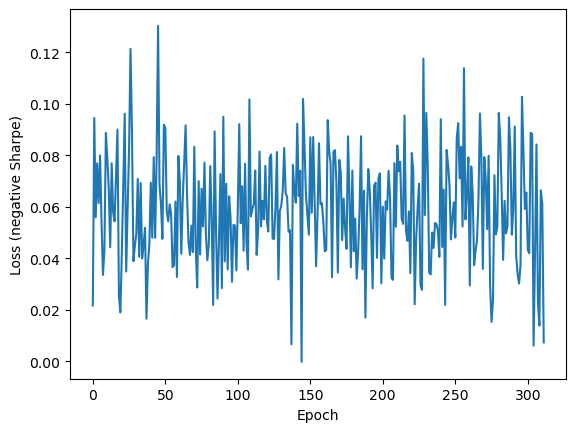

In [86]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (negative Sharpe)")
plt.show()

In [66]:
torch.tensor([1,2,3,4])[[1,3]]

tensor([2, 4])